In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import torch.nn.functional as F

# 데이터 로드
#large_train = pd.read_csv('./pre_train_project/large_dataset.csv')
#medium_train = pd.read_csv('./pre_train_project/medium_dataset.csv')
large_train = pd.read_csv('./pre_train_project/large_medium_dataset.csv')
small_train = pd.read_csv('./pre_train_project/small_dataset.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv("test_with_setting01.csv")

In [2]:
# 'WT' -> 0, 돌연변이 값 -> 1로 변환
x_train = large_train.drop(columns=['ID', 'SUBCLASS'])

x_test = test.drop(columns=['ID'])

# 레이블 인코딩 (26종의 암을 숫자로 변환)
label_encoder = LabelEncoder()
label_encoder.fit(train['SUBCLASS'])

y = label_encoder.transform(large_train['SUBCLASS'])

In [3]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


In [4]:
# 데이터셋과 데이터로더 생성
train_dataset = TensorDataset(x_train_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataset = TensorDataset(x_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
# DNN 모델 정의
class largeDataset_DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(largeDataset_DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# 하이퍼파라미터 설정
input_size = x_train.shape[1]  # 입력 피처 수
num_classes = len(np.unique(label_encoder.transform(train['SUBCLASS'])))  # 클래스 수
learning_rate = 0.001
num_epochs = 100

In [9]:
# 모델, 손실 함수, 옵티마이저 정의
model = largeDataset_DNN(input_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # , weight_decay=weight_decay
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# early stop & acc visualization setting
best_loss = float('inf')
early_stop_counter = 0
patience = 8
loss_list = []
acc_list = []

# 모델 학습
model.train()
for epoch in range(num_epochs):
    correct_total = 0
    n_iter = 0
    loss_total = 0.0

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        loss_total += loss.item()
        pred = outputs.argmax(dim=-1)
        correct_total += pred.eq(labels).sum().item()
        n_iter += 1

    epoch_loss = loss_total / n_iter
    epoch_acc = correct_total / len(x_train) * 100

    loss_list.append(epoch_loss)
    acc_list.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {epoch_acc:.2f}%')
    
    # 학습률 스케줄러 업데이트
    scheduler.step()
    
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

Epoch [1/100], Loss: 3.3228, Accuracy: 43.99%
Epoch [2/100], Loss: 0.1032, Accuracy: 65.44%
Epoch [3/100], Loss: 0.0000, Accuracy: 76.49%
Epoch [4/100], Loss: 2.6202, Accuracy: 82.00%
Epoch [5/100], Loss: 0.0000, Accuracy: 85.18%
Epoch [6/100], Loss: 0.1862, Accuracy: 87.21%
Epoch [7/100], Loss: 0.4010, Accuracy: 88.63%
Epoch [8/100], Loss: 0.0026, Accuracy: 89.65%
Epoch [9/100], Loss: 0.0000, Accuracy: 90.29%
Epoch [10/100], Loss: 0.0000, Accuracy: 90.74%
Epoch [11/100], Loss: 0.0000, Accuracy: 91.17%
Epoch [12/100], Loss: 0.0000, Accuracy: 91.42%
Epoch [13/100], Loss: 0.0000, Accuracy: 91.51%
Epoch [14/100], Loss: 0.1685, Accuracy: 91.82%
Epoch [15/100], Loss: 2.3660, Accuracy: 91.89%
Epoch [16/100], Loss: 0.0000, Accuracy: 92.07%
Epoch [17/100], Loss: 0.0000, Accuracy: 92.13%
Epoch [18/100], Loss: 0.0000, Accuracy: 92.21%
Epoch [19/100], Loss: 0.0000, Accuracy: 92.27%
Epoch [20/100], Loss: 0.0000, Accuracy: 92.37%
Epoch [21/100], Loss: 0.0000, Accuracy: 92.37%
Epoch [22/100], Loss: 

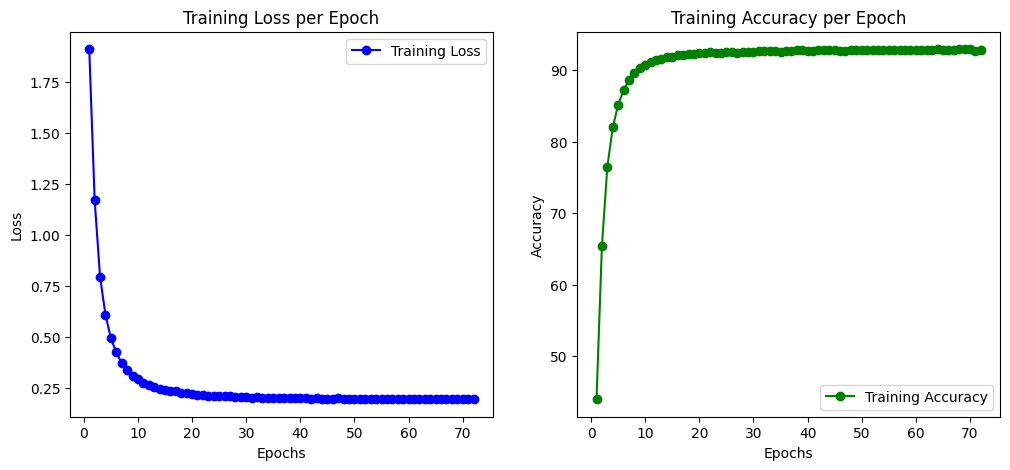

In [10]:
import matplotlib.pyplot as plt

# 학습 손실 및 정확도 시각화
epochs = range(1, len(loss_list) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_list, 'bo-', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_list, 'go-', label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [11]:
# Save the model's weights
torch.save(model.state_dict(), './pre_train_project/trained_large_medium_model_weights.pth')

In [53]:
x_train = medium_train.drop(columns=['ID', 'SUBCLASS'])
x_train = x_train.to_numpy()
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)

y = label_encoder.transform(medium_train['SUBCLASS'])
y_tensor = torch.tensor(y, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

In [54]:
# DNN 모델 정의
class mediumDataset_DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(mediumDataset_DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# 하이퍼파라미터 설정
learning_rate = 0.0001
num_epochs = 10

In [55]:
# 모델, 손실 함수, 옵티마이저 정의
model = mediumDataset_DNN(input_size, num_classes).to(device)

model.load_state_dict(torch.load('./pre_train_project/trained_large_model_weights.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # , weight_decay=weight_decay
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# early stop & acc visualization setting
best_loss = float('inf')
early_stop_counter = 0
patience = 8
loss_list = []
acc_list = []

# 모델 학습
model.train()
for epoch in range(num_epochs):
    correct_total = 0
    n_iter = 0
    loss_total = 0.0

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        loss_total += loss.item()
        pred = outputs.argmax(dim=-1)
        correct_total += pred.eq(labels).sum().item()
        n_iter += 1

    epoch_loss = loss_total / n_iter
    epoch_acc = correct_total / len(x_train) * 100

    loss_list.append(epoch_loss)
    acc_list.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {epoch_acc:.2f}%')
    
    # 학습률 스케줄러 업데이트
    scheduler.step()
    
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

C:\Users\hwcho\AppData\Local\Temp\ipykernel_2440\2135916242.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./pre_train_project/trained

Epoch [1/10], Loss: 2.4765, Accuracy: 26.83%
Epoch [2/10], Loss: 1.4337, Accuracy: 37.37%
Epoch [3/10], Loss: 1.8850, Accuracy: 42.20%
Epoch [4/10], Loss: 1.7188, Accuracy: 46.43%
Epoch [5/10], Loss: 1.8281, Accuracy: 50.55%
Epoch [6/10], Loss: 1.4732, Accuracy: 53.92%
Epoch [7/10], Loss: 1.6126, Accuracy: 58.24%
Epoch [8/10], Loss: 1.2077, Accuracy: 61.65%
Epoch [9/10], Loss: 1.5697, Accuracy: 64.88%
Epoch [10/10], Loss: 1.2173, Accuracy: 68.18%


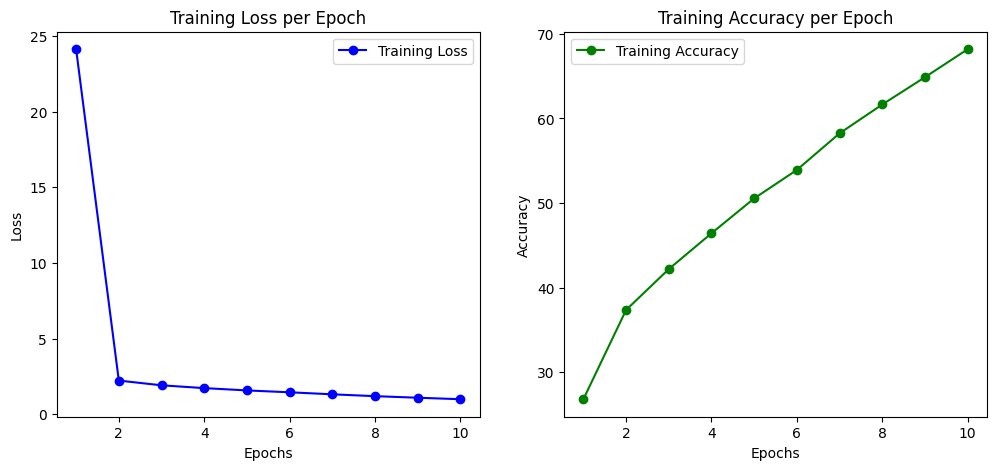

In [56]:
import matplotlib.pyplot as plt

# 학습 손실 및 정확도 시각화
epochs = range(1, len(loss_list) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_list, 'bo-', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_list, 'go-', label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [57]:
torch.save(model.state_dict(), './pre_train_project/trained_medium_model_weights.pth')

In [12]:
x_train = small_train.drop(columns=['ID', 'SUBCLASS'])
x_train = x_train.to_numpy()
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)

y = label_encoder.transform(small_train['SUBCLASS'])
y_tensor = torch.tensor(y, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

In [13]:
# DNN 모델 정의
class smallDataset_DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(smallDataset_DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.4)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# 하이퍼파라미터 설정
learning_rate = 0.00001
num_epochs = 10

In [14]:
# 모델, 손실 함수, 옵티마이저 정의
model = smallDataset_DNN(input_size, num_classes).to(device)

#model.load_state_dict(torch.load('./pre_train_project/trained_medium_model_weights.pth'))
model.load_state_dict(torch.load('./pre_train_project/trained_large_medium_model_weights.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # , weight_decay=weight_decay
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# early stop & acc visualization setting
best_loss = float('inf')
early_stop_counter = 0
patience = 8
loss_list = []
acc_list = []

# 모델 학습
model.train()
for epoch in range(num_epochs):
    correct_total = 0
    n_iter = 0
    loss_total = 0.0

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        loss_total += loss.item()
        pred = outputs.argmax(dim=-1)
        correct_total += pred.eq(labels).sum().item()
        n_iter += 1

    epoch_loss = loss_total / n_iter
    epoch_acc = correct_total / len(x_train) * 100

    loss_list.append(epoch_loss)
    acc_list.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {epoch_acc:.2f}%')
    
    # 학습률 스케줄러 업데이트
    # scheduler.step()
    
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

C:\Users\hwcho\AppData\Local\Temp\ipykernel_4232\3813591193.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./pre_train_project/trained

Epoch [1/10], Loss: 4.8257, Accuracy: 71.50%
Epoch [2/10], Loss: 10.8401, Accuracy: 71.87%
Epoch [3/10], Loss: 29.3442, Accuracy: 71.67%
Epoch [4/10], Loss: 6.7810, Accuracy: 71.97%
Epoch [5/10], Loss: 10.5128, Accuracy: 72.04%
Epoch [6/10], Loss: 10.9179, Accuracy: 71.94%
Epoch [7/10], Loss: 8.4616, Accuracy: 72.04%
Epoch [8/10], Loss: 2.5149, Accuracy: 72.11%
Epoch [9/10], Loss: 1.8226, Accuracy: 72.07%
Epoch [10/10], Loss: 3.0030, Accuracy: 71.94%


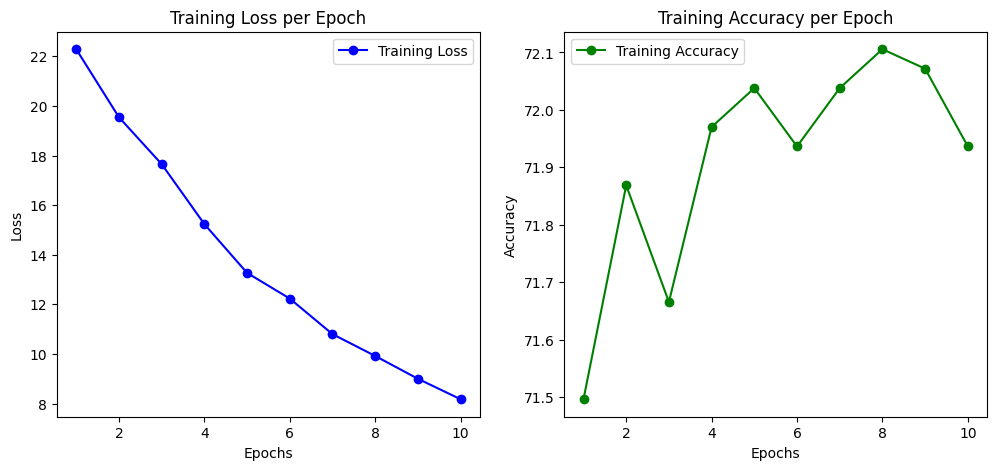

In [15]:
# 학습 손실 및 정확도 시각화
epochs = range(1, len(loss_list) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_list, 'bo-', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_list, 'go-', label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [6]:
import torch

model = largeDataset_DNN(input_size, num_classes).to(device)

model.load_state_dict(torch.load('./pre_train_project/trained_large_medium_model_weights.pth'))

# 모델 평가
model.eval()
predictions = []

# 예측 수행
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # 각 샘플의 최대 확률을 가진 클래스 예측
        predictions.extend(predicted.cpu().numpy())  # predicted 값을 리스트에 추가

# predictions 리스트는 라벨 인코딩 된 클래스 값으로 변환
original_labels = label_encoder.inverse_transform(predictions)

# 샘플 제출 파일 로드
submission = pd.read_csv("./sample_submission.csv")

# 'SUBCLASS' 열에 예측된 레이블 추가
submission["SUBCLASS"] = original_labels


# 제출 파일 저장
submission.to_csv('./pre_train_project/submission.csv', encoding='UTF-8-sig', index=False)

unique_values = submission['SUBCLASS'].value_counts()
print(unique_values)
print(unique_values.shape)

print("Submission file saved as 'submission.csv'")

C:\Users\hwcho\AppData\Local\Temp\ipykernel_1028\343750124.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./pre_train_project/trained_

SUBCLASS
BRCA      279
STES      253
COAD      232
KIPAN     212
PAAD      182
KIRC      136
GBMLGG    129
THCA      117
PRAD      107
SKCM       96
LUAD       93
LIHC       92
OV         89
HNSC       84
UCEC       82
SARC       76
LGG        64
CESC       55
LAML       52
TGCT       46
BLCA       40
DLBC       16
LUSC       14
Name: count, dtype: int64
(23,)
Submission file saved as 'submission.csv'
